In [ ]:
#@title Run this cell to mount Google Drive and get `kaggle.json` from personal directory

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pathlib import Path

# TEMPORARY CHANGE
DATASET_DIR = Path("./drive/My Drive/bdb-2025/working/datasets/")

# Step: Model Implementation



In [ ]:
!wget https://raw.githubusercontent.com/illydh/2025-nfl-bdb/refs/heads/main/scripts/process_datasets.py

--2025-01-07 03:06:20--  https://raw.githubusercontent.com/illydh/2025-nfl-bdb/refs/heads/main/scripts/process_datasets.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9476 (9.3K) [text/plain]
Saving to: ‘process_datasets.py’

process_datasets.py 100%[===================>]   9.25K  --.-KB/s    in 0s      

2025-01-07 03:06:20 (134 MB/s) - ‘process_datasets.py’ saved [9476/9476]



## Load Datasets

In [ ]:
import torch
from torch.utils.data import DataLoader
from process_datasets import load_datasets
from process_datasets import BDB2025_Dataset

# Load preprocessed datasets
train_dataset = load_datasets(model_type='transformer', split='train')
val_dataset = load_datasets(model_type='transformer', split='val')
test_dataset = load_datasets(model_type='transformer', split='test')

In [ ]:
# Create DataLoader objects
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=3)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=3)

In [ ]:
# Print feature and target shapes from DataLoaders
for batch in train_loader:
    features, targets = batch
    print("Train features shape:", features.shape)
    print("Train targets shape:", targets.shape)
    break

Train features shape: torch.Size([128, 21, 3])
Train targets shape: torch.Size([128, 3])


## Load Model

In [ ]:
!wget https://raw.githubusercontent.com/illydh/2025-nfl-bdb/refs/heads/main/scripts/models.py

--2025-01-05 23:30:10--  https://raw.githubusercontent.com/illydh/2025-nfl-bdb/refs/heads/main/scripts/models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8086 (7.9K) [text/plain]
Saving to: ‘models.py’

models.py           100%[===================>]   7.90K  --.-KB/s    in 0s      

2025-01-05 23:30:11 (109 MB/s) - ‘models.py’ saved [8086/8086]



In [ ]:
!pip install pytorch-lightning  #  module not included in colab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 41.2 MB/s eta 0:00:00


In [ ]:
#import models
#from models import GhostFormer
#from models import GhostFormerLitModel

"""
Model Architectures for NFL Big Data Bowl 2025 prediction task

This module defines neural network architectures for predicting ouptuts in NFL Plays. It includes a generalized transformer-based model for
processing sports tracking data and a LightningModule wrapper for training and evaluation.

Classes:
    GhostFormer: Generalized Transformer-based model for sports tracking data.
    GhostFormerLitModel: LightningModule wrapper for shared training functionality.
"""

from typing import Any
import torch
from torch import Tensor, nn, squeeze
from torch.optim import AdamW
from pytorch_lightning import LightningModule

torch.set_float32_matmul_precision("medium")

class GhostFormer(nn.Module):
    """Transformer model for predicting masked player position and coordinates."""

    def __init__(
        self,
        feature_len: int = 3,
        model_dim: int = 32,
        num_layers: int = 10,
        output_dim: int = 3,
        dropout: float = 0.1,
        num_positions: int = 18,  # Number of possible positions
    ):
        super().__init__()
        dim_feedforward = model_dim * 4
        num_heads = min(16, max(2, 2 * round(model_dim / 64)))

        self.hyperparams = {
            "model_dim": model_dim,
            "num_layers": num_layers,
            "num_heads": num_heads,
            "dim_feedforward": dim_feedforward,
        }

        self.feature_norm_layer = nn.BatchNorm1d(feature_len)
        self.feature_embedding_layer = nn.Sequential(
            nn.Linear(feature_len, model_dim),
            nn.ReLU(),
            nn.LayerNorm(model_dim),
            nn.Dropout(dropout),
        )

        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=model_dim,
                nhead=num_heads,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                batch_first=True,
            ),
            num_layers=num_layers,
        )

        self.player_pooling_layer = nn.AdaptiveAvgPool1d(1)

        # Separate decoders for position and coordinates
        self.position_decoder = nn.Sequential(
            nn.Linear(model_dim, model_dim // 4),
            nn.ReLU(),
            nn.LayerNorm(model_dim // 4),
            nn.Linear(model_dim // 4, num_positions),  # Predict position index
        )

        self.coordinate_decoder = nn.Sequential(
            nn.Linear(model_dim, model_dim // 4),
            nn.ReLU(),
            nn.LayerNorm(model_dim // 4),
            nn.Linear(model_dim // 4, 2),  # Predict x and y coordinates
        )

    def forward(self, x: Tensor) -> tuple[Tensor, Tensor]:
        B, P, F = x.size()

        x = self.feature_norm_layer(x.permute(0, 2, 1)).permute(0, 2, 1)
        x = self.feature_embedding_layer(x)
        x = self.transformer_encoder(x)
        x = squeeze(self.player_pooling_layer(x.permute(0, 2, 1)), -1)

        position_logits = self.position_decoder(x)  # [B, num_positions]
        coordinates = self.coordinate_decoder(x)  # [B, 2]

        return position_logits, coordinates

In [ ]:
class GhostFormerLitModel(LightningModule):
    def __init__(
        self,
        feature_len: int,
        batch_size: int,
        model_dim: int,
        num_layers: int,
        output_dim: int,
        dropout: float = 0.1,
        learning_rate: float = 1e-3,
        num_positions: int = 18,
    ):
        super().__init__()
        self.feature_len = feature_len
        self.num_positions = num_positions
        self.model = GhostFormer(
            feature_len=self.feature_len, model_dim=model_dim, num_layers=num_layers, dropout=dropout, num_positions=self.num_positions
        )
        self.example_input_array = torch.randn((batch_size, 21, self.feature_len))
        self.learning_rate = learning_rate
        self.num_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        self.hparams["params"] = self.num_params
        for k, v in self.model.hyperparams.items():
            self.hparams[k] = v
        self.save_hyperparameters()
        self.position_loss_fn = torch.nn.CrossEntropyLoss()
        self.coordinate_loss_fn = torch.nn.MSELoss()  # Or L1Loss

    def forward(self, x: Tensor) -> tuple[Tensor, Tensor]:
        if isinstance(x, list):
            x = torch.stack(x)
        return self.model(x)

    def training_step(self, batch: tuple[Tensor, Tensor, Tensor], batch_idx: int) -> Tensor:
        x, y = batch
        position_target = y[:, 0].long()      # Extract position (batch_size,)
        coordinate_target = y[:, 1:]    # Extract coordinates (batch_size, 2)
        position_logits, coordinates = self.model(x)
        position_loss, coordinate_loss = self.loss_fn(position_logits, position_target, coordinates, coordinate_target)
        # Scaling factors (adjust these based on your data and initial experiments)
        position_scale = 1  # You might not need to scale cross entropy as much
        coordinate_scale = 0.01  # Example if your MSE is much smaller. Adjust as needed.

        loss = (position_loss * position_scale) + (coordinate_loss * coordinate_scale)
        self.log("train_position_loss", position_loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("train_coordinate_loss", coordinate_loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        return loss

    def validation_step(self, batch: tuple[Tensor, Tensor, Tensor], batch_idx: int) -> Tensor:
        x, y = batch
        position_target = y[:, 0].long()      # Extract position (batch_size,)
        coordinate_target = y[:, 1:]    # Extract coordinates (batch_size, 2)
        position_logits, coordinates = self.model(x)
        position_loss, coordinate_loss = self.loss_fn(position_logits, position_target, coordinates, coordinate_target)
        # Scaling factors (adjust these based on your data and initial experiments)
        position_scale = 1  # You might not need to scale cross entropy as much
        coordinate_scale = 0.01  # Example if your MSE is much smaller. Adjust as needed.

        loss = (position_loss * position_scale) + (coordinate_loss * coordinate_scale)
        self.log("val_position_loss", position_loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("val_coordinate_loss", coordinate_loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        return loss

    def predict_step(self, batch: tuple[Tensor, Tensor, Tensor], batch_idx: int, dataloader_idx: int = 0) -> tuple[Tensor, Tensor]:
        x, _ = batch  # We don't need targets for prediction
        if isinstance(x, list):
            x = torch.stack(x)
        position_logits, coordinates = self.model(x)
        return position_logits, coordinates

    def configure_optimizers(self) -> AdamW:
        return AdamW(self.parameters(), lr=self.learning_rate)

    def loss_fn(self, position_logits, position_tgt, coordinates, coordinate_tgt):
        position_loss = self.position_loss_fn(position_logits, position_tgt)

        sq_distances = torch.square(coordinate_tgt - coordinates)
        sq_distances_reshaped = sq_distances.reshape(sq_distances.shape[0], sq_distances.shape[-1] // 2, 2)
        sum_pool = torch.sum(sq_distances_reshaped, dim=-1)
        dists = torch.sqrt(sum_pool)
        coordinate_loss = torch.mean(dists)
        return position_loss, coordinate_loss



In [ ]:
# Model parameters
feature_len = 3  # Adjust this as needed based on input data
model_dim = 32  # Dimension of transformer model (adjustable)
num_layers = 10  # Number of transformer layers (adjustable)
dropout = 0.1
learning_rate = 5e-3
batch_size = 128   #   adjust when analyzing all tracking information
output_dim = 3
epochs = 20

# Initialize the model
model = GhostFormerLitModel(
    feature_len=feature_len,
    batch_size=batch_size,
    model_dim=model_dim,
    num_layers=num_layers,
    output_dim=output_dim,
    dropout=dropout,
    learning_rate=learning_rate,
)

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pathlib import Path

# Define checkpointing to save the best model
checkpoint_callback = ModelCheckpoint(
   dirpath=Path("./drive/My Drive/bdb-2025/working/checkpoints"),      # adjustable dir path
   filename="best-checkpoint",
   save_top_k=1,
   verbose=True,
   monitor="val_loss",
   mode="min",
)

# Define early stopping
early_stop_callback = EarlyStopping(
   monitor="val_loss",
   min_delta=0.01,  # Minimum change in monitored value to qualify as an improvement
   patience=3,      # Number of epochs with no improvement after which training will be stopped
   verbose=True,
   mode="min"
)

# Initialize the trainer
trainer = Trainer(
   max_epochs=epochs,  # Adjust the number of epochs
   accelerator="gpu",  # Use 'gpu' if CUDA is available, otherwise use 'cpu'
   devices=1,
   callbacks=[checkpoint_callback, early_stop_callback],
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# Start training
trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/My Drive/bdb-2025/working/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type             | Params | Mode  | In sizes     | Out sizes            
-------------------------------------------------------------------------------------------------------
0 | model              | GhostFormer      | 127 K  | train | [128, 21, 3] | [[128, 18], [128, 2]]
1 | position_loss_fn   | CrossEntropyLoss | 0      | train | ?            | ?                    
2 | coordinate_loss_fn | MSELoss          | 0      | train | ?            | ?                    
-------------------------------------------------------------------------------------------------------
127 K     Trainable params
0         Non-trainable params
127 K     Total par

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 2.278
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 11170: 'val_loss' reached 2.27786 (best 2.27786), saving model to '/content/drive/My Drive/bdb-2025/working/checkpoints/best-checkpoint-v21.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 22340: 'val_loss' reached 2.27533 (best 2.27533), saving model to '/content/drive/My Drive/bdb-2025/working/checkpoints/best-checkpoint-v21.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 33510: 'val_loss' reached 2.27425 (best 2.27425), saving model to '/content/drive/My Drive/bdb-2025/working/checkpoints/best-checkpoint-v21.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 2.278. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 44680: 'val_loss' was not in top 1


In [ ]:
#@title Load in model from best checkpoint

checkpoint_path = Path("./drive/My Drive/bdb-2025/working/checkpoints/best-checkpoint-v1.ckpt")
model = GhostFormerLitModel.load_from_checkpoint(checkpoint_path)

In [ ]:
# Inference on test data
predictions = trainer.predict(model, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# Assuming 'predictions' is the output from trainer.predict as in your provided code.
# 'predictions' will be a list of tuples, where each tuple contains the position logits and coordinates for a batch.

pred_position_logits = []
pred_coordinates = []

for batch_predictions in predictions:
  position_logits, coordinates = batch_predictions
  pred_position_logits.append(position_logits)
  pred_coordinates.append(coordinates)

# Convert the lists of tensors to single tensors
pred_position_logits = torch.cat(pred_position_logits, dim=0)
pred_coordinates = torch.cat(pred_coordinates, dim=0)

print("Shape of all_position_logits tensor:", pred_position_logits.shape)
print("Shape of all_coordinates tensor:", pred_coordinates.shape)

Shape of all_position_logits tensor: torch.Size([307934, 19])
Shape of all_coordinates tensor: torch.Size([307934, 2])


In [ ]:
# Get predicted labels for position, x, and y
pred_positions = torch.argmax(pred_position_logits, dim=1)
pred_x = pred_coordinates[:, 0]
pred_y = pred_coordinates[:, 1]

print("Predicted positions:", pred_positions)
print("Predicted x-coordinates:", pred_x)
print("Predicted y-coordinates:", pred_y)

Predicted positions: tensor([7, 5, 1,  ..., 3, 3, 7])
Predicted x-coordinates: tensor([49.9741, 34.6829, 57.2942,  ..., 21.8491, 41.4774,  8.1385])
Predicted y-coordinates: tensor([28.7432, 23.5582, 32.7115,  ..., 30.0711, 23.9859, 26.6698])


In [ ]:
# Extract true labels from test_loader
y_true = torch.cat([y for _, y in test_loader], dim=0).cpu().detach().numpy()
y_true_positions = y_true[:, 0]
y_true_x = y_true[:, 1]
y_true_y = y_true[:, 2]

In [ ]:
import numpy as np

# Extract true labels from the test_loader
y_true = torch.cat([y for _, y in test_loader], dim=0)

# Convert tensors to numpy arrays if needed for sklearn functions
pred_positions_np = pred_positions.cpu().numpy()
pred_x_np = pred_x.cpu().numpy()
pred_y_np = pred_y.cpu().numpy()

print("True positions shape:", y_true_positions.shape)
print("True x-coordinates shape:", y_true_x.shape)
print("True y-coordinates shape:", y_true_y.shape)
print("Predicted positions shape:", pred_positions_np.shape)
print("Predicted x-coordinates shape:", pred_x_np.shape)
print("Predicted y-coordinates shape:", pred_y_np.shape)

True positions shape: (307934,)
True x-coordinates shape: (307934,)
True y-coordinates shape: (307934,)
Predicted positions shape: (307934,)
Predicted x-coordinates shape: (307934,)
Predicted y-coordinates shape: (307934,)


In [ ]:
import pandas as pd

# Create a test dataframe
df_test = pd.DataFrame({
    'gameId': [key[0] for key in test_dataset.keys],
    'playId': [key[1] for key in test_dataset.keys],
    'frameId': [key[2] for key in test_dataset.keys],
    'true_positions': y_true_positions,
    'pred_positions': pred_positions_np,
    'true_x': y_true_x,
    'pred_x': pred_x_np,
    'true_y': y_true_y,
    'pred_y': pred_y_np,
})

In [ ]:
test_dir = Path("./drive/My Drive/bdb-2025/prepped_data/split/test_features.parquet")

# Attach metadata and filter to ball_snap event only
df_test_metadata = pd.read_parquet(test_dir)

df_test = df_test.merge(df_test_metadata[["gameId", "playId", "frameId"]], on=["gameId", "playId", "frameId"], how="left")

In [ ]:
df_test = df_test.drop_duplicates(subset=['gameId', 'playId', 'frameId'])

df_test = df_test.sort_values(['gameId', 'playId', 'frameId']).reset_index(drop=True)

display(df_test)

,gameId,playId,frameId,true_positions,pred_positions,true_x,pred_x,true_y,pred_y
0,2022090800,80,1,3.0,3,77.589996,71.641075,32.529999,25.279160
1,2022090800,80,2,1.0,1,71.849998,71.693390,14.320000,12.579436
2,2022090800,80,3,1.0,1,71.830002,71.781670,14.100000,12.486002
3,2022090800,80,4,5.0,14,69.440002,69.394943,36.790001,23.258284
4,2022090800,80,5,1.0,1,71.790001,71.928291,13.690000,12.316042
...,...,...,...,...,...,...,...,...,...
27989,2022091200,3574,134,11.0,11,82.370003,78.149025,29.530001,28.576038
27990,2022091200,3574,135,11.0,11,82.379997,78.157799,29.540001,28.549580
27991,2022091200,3574,136,7.0,7,77.220001,75.791512,24.180000,25.007153
27992,2022091200,3574,137,11.0,11,82.110001,77.666428,17.740000,21.215538


In [ ]:
true_labels = df_test[['true_positions', 'true_x', 'true_y']].values
predicted_labels = df_test[['pred_positions', 'pred_x', 'pred_y']].values

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'

# Enumerate player positions
POSITIONS_ENUM = {
    'C': 0,
    'CB': 1,
    'DE': 2,
    'DT': 3,
    'FB': 4,
    'FS': 5,
    'G': 6,
    'ILB': 7,
    'LB': 8,
    'MLB': 9,
    'NT': 10,
    'OLB': 11,
    'QB': 12,
    'RB': 13,
    'SS': 14,
    'T': 15,
    'TE': 16,
    'WR': 17
}

# Get class labels from FORMATION_ENUM and sort alphabetically
position_labels = sorted(list(POSITIONS_ENUM.keys()))

In [ ]:
# Print unique values to debug
print("Unique values in true labels:", np.unique(true_labels))
print("Unique values in predicted labels:", np.unique(predicted_labels))
print("Positions enum values:", POSITIONS_ENUM)

Unique values in true labels: [  1.     2.     3.   ... 115.27 115.3  115.32]
Unique values in predicted labels: [  1.           2.           3.         ... 108.10637665 108.12667084
 108.13478851]
Positions enum values: {'C': 0, 'CB': 1, 'DE': 2, 'DT': 3, 'FB': 4, 'FS': 5, 'G': 6, 'ILB': 7, 'LB': 8, 'MLB': 9, 'NT': 10, 'OLB': 11, 'QB': 12, 'RB': 13, 'SS': 14, 'T': 15, 'TE': 16, 'WR': 17}


# Step: Evaluation

In [ ]:
#@title Position Labels

# Extract only the position labels (first column) for classification metrics
true_positions = true_labels[:, 0]
predicted_positions = predicted_labels[:, 0]

# Calculate metrics using only position labels
accuracy = accuracy_score(true_positions, predicted_positions)
precision = precision_score(true_positions, predicted_positions, average='weighted',
                         labels=np.unique(true_positions))  # Use unique true labels
recall = recall_score(true_positions, predicted_positions, average='weighted',
                    labels=np.unique(true_positions))  # Use unique true labels
f1 = f1_score(true_positions, predicted_positions, average='weighted',
             labels=np.unique(true_positions))  # Use unique true labels

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.6836464956776452
Precision: 0.6836546050538403
Recall: 0.6836464956776452
F1 Score: 0.6760794268336782


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Extract x and y coordinates from true and predicted labels
true_x = true_labels[:, 1]
predicted_x = predicted_labels[:, 1]
true_y = true_labels[:, 2]
predicted_y = predicted_labels[:, 2]

# Calculate MAE and MSE for x-coordinates
mae_x = mean_absolute_error(true_x, predicted_x)
mse_x = mean_squared_error(true_x, predicted_x)
rmse_x = np.sqrt(mse_x)  # Calculate RMSE

print(f"MAE for x-coordinates: {mae_x}")
print(f"MSE for x-coordinates: {mse_x}")
print(f"RMSE for x-coordinates: {rmse_x}\n")

# Calculate MAE and MSE for y-coordinates
mae_y = mean_absolute_error(true_y, predicted_y)
mse_y = mean_squared_error(true_y, predicted_y)
rmse_y = np.sqrt(mse_y)  # Calculate RMSE

print(f"MAE for y-coordinates: {mae_y}")
print(f"MSE for y-coordinates: {mse_y}")
print(f"RMSE for y-coordinates: {rmse_y}")

MAE for x-coordinates: 2.819957033194686
MSE for x-coordinates: 13.049831474427465
RMSE for x-coordinates: 3.612455048083985

MAE for y-coordinates: 3.1859183863008704
MSE for y-coordinates: 18.170749297458872
RMSE for y-coordinates: 4.262716187767944


### CONFUSION MATRIX



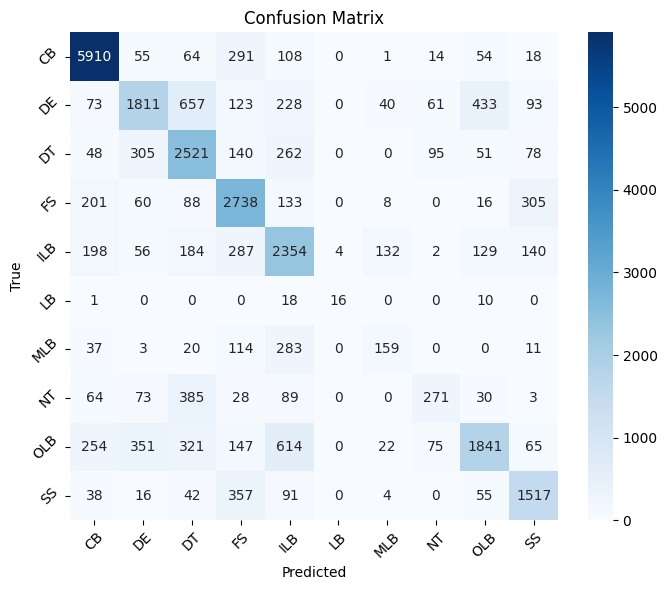

In [ ]:
# Create confusion matrix only for classes that appear in the data
present_classes = sorted(list(set(np.unique(true_positions)) | set(np.unique(predicted_positions))))
conf_matrix = confusion_matrix(true_positions, predicted_positions,
                            labels=present_classes)

# Get labels for present classes
present_labels = [position_labels[int(i)] for i in present_classes]

# Plot confusion matrix with labels for present classes
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix,
          annot=True,
          fmt='d',
          cmap='Blues',
          xticklabels=present_labels,
          yticklabels=present_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Show example play
df_play = df_test[((df_test.playId == 64))]

df_tracking_test = pd.read_parquet('./drive/My Drive/bdb-2025/prepped_data/split/test_features.parquet')
df_tgt_test = pd.read_parquet('./drive/My Drive/bdb-2025/prepped_data/split/test_targets.parquet')

df_example_play = df_tracking_test[((df_tracking_test.playId == 64) & (df_tracking_test.maskedId == 1))]
df_example_tgt = df_tgt_test[((df_tgt_test.playId == 64) & (df_tgt_test.maskedId == 1))]

df_example_play = df_example_play.merge(df_play[["gameId", "playId", "frameId"]], on=["gameId", "playId", "frameId"], how="left").reset_index()
#df_example_tgt = df_example_tgt.merge(df_play[["gameId", "playId", "frameId", "pred_positions", "pred_x", "pred_y"]], on=["gameId", "playId", "frameId"], how="left").reset_index()
df_example_play['isMasked'] = False
df_example_play['isPredicted'] = False
display(df_example_play)

,index,gameId,playId,frameId,maskedId,nflId,displayName,position,x,y,isMasked,isPredicted
0,0,2022091102,64,1,1,42360,Arik Armstead,DT,84.69,30.58,False,False
1,1,2022091102,64,1,1,53580,Larry Borom,T,92.34,31.07,False,False
2,2,2022091102,64,1,1,46113,Dante Pettis,WR,93.15,28.55,False,False
3,3,2022091102,64,1,1,46139,Fred Warner,ILB,82.92,28.96,False,False
4,4,2022091102,64,1,1,46276,Equanimeous St. Brown,WR,94.48,29.95,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2095,2095,2022091102,64,100,1,46139,Fred Warner,ILB,84.20,22.68,False,False
2096,2096,2022091102,64,100,1,53440,Justin Fields,QB,91.84,29.82,False,False
2097,2097,2022091102,64,100,1,46276,Equanimeous St. Brown,WR,88.38,10.35,False,False
2098,2098,2022091102,64,100,1,38868,Tashaun Gipson,FS,75.28,17.38,False,False


In [ ]:
df_example_tgt_actual = df_example_tgt.merge(df_play[["gameId", "playId", "frameId"]], on=["gameId", "playId", "frameId"], how="left").reset_index()
df_example_tgt_actual['isMasked'] = True
df_example_tgt_actual['isPredicted'] = False
display(df_example_tgt_actual)

,index,gameId,playId,frameId,maskedId,displayName,position,x,y,isMasked,isPredicted
0,0,2022091102,64,1,1,Dre Greenlaw,ILB,82.50,30.36,True,False
1,1,2022091102,64,2,1,Dre Greenlaw,ILB,82.38,30.44,True,False
2,2,2022091102,64,3,1,Dre Greenlaw,ILB,82.26,30.50,True,False
3,3,2022091102,64,4,1,Dre Greenlaw,ILB,82.14,30.56,True,False
4,4,2022091102,64,5,1,Dre Greenlaw,ILB,82.01,30.62,True,False
...,...,...,...,...,...,...,...,...,...,...,...
95,95,2022091102,64,96,1,Dre Greenlaw,ILB,81.57,28.81,True,False
96,96,2022091102,64,97,1,Dre Greenlaw,ILB,81.56,28.82,True,False
97,97,2022091102,64,98,1,Dre Greenlaw,ILB,81.55,28.82,True,False
98,98,2022091102,64,99,1,Dre Greenlaw,ILB,81.55,28.81,True,False


In [ ]:

df_example_tgt_pred = df_example_tgt.copy()
df_example_tgt_pred['x'] = df_play['pred_x'].values
df_example_tgt_pred['y'] = df_play['pred_y'].values
df_example_tgt_pred['position'] = df_play['pred_positions'].values
df_example_tgt_pred['isMasked'] = True
df_example_tgt_pred['isPredicted'] = True
display(df_example_tgt_pred)

,gameId,playId,frameId,maskedId,displayName,position,x,y,isMasked,isPredicted
53532,2022091102,64,1,1,Dre Greenlaw,3,83.244446,28.505081,True,True
53546,2022091102,64,2,1,Dre Greenlaw,11,83.531853,32.734482,True,True
53552,2022091102,64,3,1,Dre Greenlaw,11,81.068726,28.630468,True,True
53559,2022091102,64,4,1,Dre Greenlaw,11,83.338005,32.845974,True,True
53575,2022091102,64,5,1,Dre Greenlaw,11,80.937714,28.628529,True,True
...,...,...,...,...,...,...,...,...,...,...
54579,2022091102,64,96,1,Dre Greenlaw,3,82.838547,27.388691,True,True
54583,2022091102,64,97,1,Dre Greenlaw,14,77.919212,31.531805,True,True
54603,2022091102,64,98,1,Dre Greenlaw,3,82.848602,27.400429,True,True
54608,2022091102,64,99,1,Dre Greenlaw,3,82.778534,27.705851,True,True


In [ ]:
# Create a list to store your dataframes
dfs_to_concat = [df_example_play, df_example_tgt_actual, df_example_tgt_pred]

# Concatenate them vertically
concatenated_df = pd.concat(dfs_to_concat, ignore_index=True)

# Display or save the result
display(concatenated_df)

,index,gameId,playId,frameId,maskedId,nflId,displayName,position,x,y,isMasked,isPredicted
0,0.0,2022091102,64,1,1,42360.0,Arik Armstead,DT,84.690000,30.580000,False,False
1,1.0,2022091102,64,1,1,53580.0,Larry Borom,T,92.340000,31.070000,False,False
2,2.0,2022091102,64,1,1,46113.0,Dante Pettis,WR,93.150000,28.550000,False,False
3,3.0,2022091102,64,1,1,46139.0,Fred Warner,ILB,82.920000,28.960000,False,False
4,4.0,2022091102,64,1,1,46276.0,Equanimeous St. Brown,WR,94.480000,29.950000,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2295,NaN,2022091102,64,96,1,NaN,Dre Greenlaw,3,82.838547,27.388691,True,True
2296,NaN,2022091102,64,97,1,NaN,Dre Greenlaw,14,77.919212,31.531805,True,True
2297,NaN,2022091102,64,98,1,NaN,Dre Greenlaw,3,82.848602,27.400429,True,True
2298,NaN,2022091102,64,99,1,NaN,Dre Greenlaw,3,82.778534,27.705851,True,True


In [ ]:
# Function to get marker color based on player and prediction status
def get_marker_color(row):
    if row["isMasked"] == 1:  # Masked player gets a unique color
        if row["isPredicted"] == 1:  # Predicted player gets a unique color
            return 'blue'
        return 'red'
    return 'gray'  # All other players are gray

# Create a new 'marker_color' column
concatenated_df['marker_color'] = concatenated_df.apply(
    lambda row: get_marker_color(row), axis=1
)
concatenated_df

,index,gameId,playId,frameId,maskedId,nflId,displayName,position,x,y,isMasked,isPredicted,marker_color
0,0.0,2022091102,64,1,1,42360.0,Arik Armstead,DT,84.690000,30.580000,False,False,gray
1,1.0,2022091102,64,1,1,53580.0,Larry Borom,T,92.340000,31.070000,False,False,gray
2,2.0,2022091102,64,1,1,46113.0,Dante Pettis,WR,93.150000,28.550000,False,False,gray
3,3.0,2022091102,64,1,1,46139.0,Fred Warner,ILB,82.920000,28.960000,False,False,gray
4,4.0,2022091102,64,1,1,46276.0,Equanimeous St. Brown,WR,94.480000,29.950000,False,False,gray
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,NaN,2022091102,64,96,1,NaN,Dre Greenlaw,3,82.838547,27.388691,True,True,blue
2296,NaN,2022091102,64,97,1,NaN,Dre Greenlaw,14,77.919212,31.531805,True,True,blue
2297,NaN,2022091102,64,98,1,NaN,Dre Greenlaw,3,82.848602,27.400429,True,True,blue
2298,NaN,2022091102,64,99,1,NaN,Dre Greenlaw,3,82.778534,27.705851,True,True,blue


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

POSITIONS_ENUM_REV = {v: k for k, v in POSITIONS_ENUM.items()}


# Create the plot
fig = px.scatter(concatenated_df,
   x='x',
   y='y',
   color='marker_color',
   animation_frame='frameId',
   range_x=[50, 120],
   range_y=[0, 53.3],
   title='Player Positions',
   labels={'x': 'Field Length (Yards)', 'y': 'Field Width (Yards)'},
   hover_data=['displayName'],
   width=900,
   height=700,
   animation_group="displayName"
)

# Add prediction text for each frame
for frame in fig.frames:
   frameId = int(frame.name)
   prediction_idx = df_example_tgt_pred[df_example_tgt_pred.frameId == frameId]['position'].values[0]
   prediction_name = POSITIONS_ENUM_REV[prediction_idx]

   frame.layout.update(
       annotations=[{
           'text': f'Position Prediction: {prediction_name}',
           'x': 0.3,
           'y': 0.95,
           'xref': 'paper',
           'yref': 'paper',
           'showarrow': False,
           'font': {'size': 24, 'color': 'blue'},
           'xanchor': 'left',
           'yanchor': 'top'
       }]
   )

# Also add initial prediction to the base layout
initial_prediction_idx = df_example_tgt_pred[df_example_tgt_pred.frameId == df_example_tgt_pred.frameId.min()]['position'].iloc[0]
initial_prediction_name = POSITIONS_ENUM_REV[initial_prediction_idx]
fig.update_layout(
   annotations=[{
       'text': f'Position Prediction: {initial_prediction_name}',
       'x': 0.3,
       'y': 0.95,
       'xref': 'paper',
       'yref': 'paper',
       'showarrow': False,
       'font': {'size': 24, 'color': 'blue'},
       'xanchor': 'left',
       'yanchor': 'top'
   }]
)

# Rest of your layout settings
fig.update_traces(marker=dict(size=12))
fig.update_yaxes(
  scaleanchor="x",
  scaleratio=1,
)

fig.update_layout(
   updatemenus=[{
       'type': 'buttons',
       'showactive': False,
       'buttons': [{
           'label': 'Play',
           'method': 'animate',
           'args': [None, {
               'frame': {'duration': 100, 'redraw': True},
               'fromcurrent': True,
               'transition': {'duration': 100}
           }]
       }, {
           'label': 'Pause',
           'method': 'animate',
           'args': [[None], {
               'frame': {'duration': 0, 'redraw': False},
               'mode': 'immediate',
               'transition': {'duration': 0}
           }]
       }]
   }]
)

fig.update_layout(
   plot_bgcolor='#ccebd4',  # Green background for field
   yaxis=dict(
       showgrid=False,  # Remove horizontal grid
       zeroline=False,
       showticklabels=False,
   ),
   xaxis=dict(
       showgrid=False,  # Remove default grid
       zeroline=False,
       showticklabels=False,
   ),
)

# Add vertical lines every 5 yards
for yard in range(0, 121, 5):
   fig.add_shape(
       type="line",
       x0=yard,
       x1=yard,
       y0=0,
       y1=53.3,
       line=dict(
           color="white",
           width=1,
       ),
       layer='below'
   )
   # Make every 10 yard line more prominent
   if yard % 10 == 0:
       fig.add_shape(
           type="line",
           x0=yard,
           x1=yard,
           y0=0,
           y1=53.3,
           line=dict(
               color="white",
               width=2,
           ),
           layer='below'
       )

fig.show()

In [ ]:
pred_position_idx = df_example_tgt_pred['position'][54608]
pred_position_name = POSITIONS_ENUM_REV[pred_position_idx]
print(pred_position_name)

DT
